In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset
from layers import SineLayer
from gen_video import gen_video

## Load Data

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


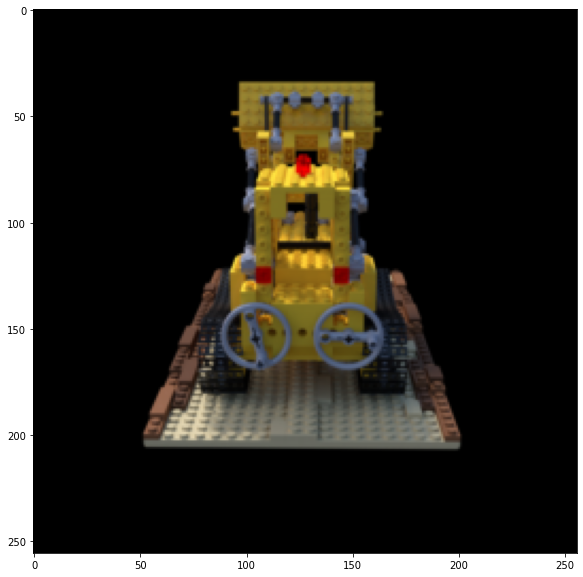

In [2]:
#dataset = Dataset('data/nerf_llff_data/fern', 'llff')
dataset = Dataset('data/nerf_synthetic/lego', 'blender')
H, W = dataset.H, dataset.W
plt.figure(figsize=(10, 10))
plt.imshow(dataset.images[0].permute(1,2,0))

## Define Models

In [3]:
feats = 64
omega_0 = 30
num_scene_points = 16

class NVSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            [SineLayer(3 * num_scene_points + 3, feats, omega_0=omega_0 * 2, is_first=True)]
            + [SineLayer(feats, feats, omega_0=omega_0) for i in range(4)]
            + [nn.Linear(feats, 3)]
        )
        
        # randomly generate scene points
        ray_sel = np.random.choice(dataset.rays.shape[0], num_scene_points)
        depth_mins = dataset.bds[ray_sel // (H * W), 0]
        depth_maxs = dataset.bds[ray_sel // (H * W), 1]
        r = np.random.rand(num_scene_points).astype(np.float32)
        dists = depth_mins + r * (depth_maxs - depth_mins)
        dists = torch.tensor(dists[:, None], device='cuda')
        self.scene_points = dataset.rays[ray_sel, :3] + dataset.rays[ray_sel, 3:] * dists
    
    def forward(self, rays):
        # localize ray origins
        ray_origins = rays[:, :3].repeat_interleave(num_scene_points, dim=0)
        dirs_repeat = rays[:, 3:].repeat_interleave(num_scene_points, dim=0)
        scene_points = self.scene_points.repeat(rays.shape[0], 1)
        ro_to_points = scene_points - ray_origins
        t = (ro_to_points * dirs_repeat).sum(-1, keepdims=True)
        local_ro = ray_origins + dirs_repeat * t
        local_ro = local_ro.reshape(rays.shape[0], -1)
        
        local_ro = local_ro * .05
        local_rays = torch.cat([local_ro, rays[:, 3:]], axis=-1)
        
        h = local_rays
        for i, layer in enumerate(self.layers):
            h = layer(h)
        return h
        

model = NVSModel()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: max(0.6 ** epoch, .01))

losses = []

## Train

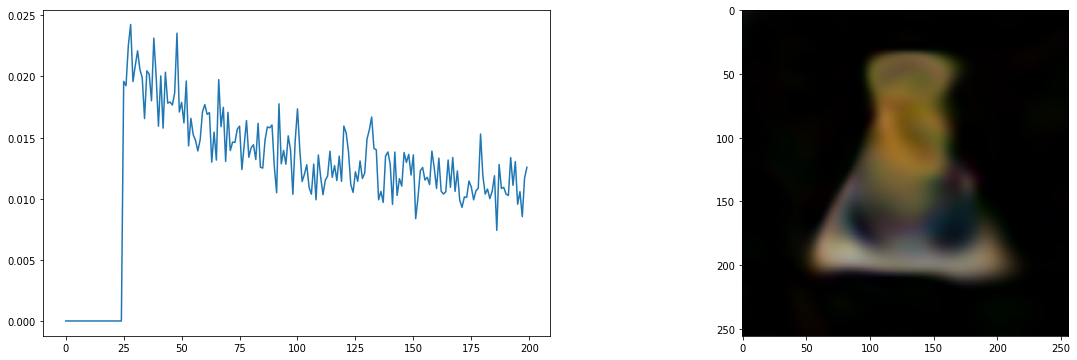

loss: 0.012570356950163841


In [4]:
batch_size = 512

for i in range(2000):
    sel = np.random.choice(dataset.rays.shape[0], batch_size)
    pred = model(dataset.rays[sel])
    loss = loss_fn(pred, dataset.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        if len(losses) < 25:
            losses.append(0) # cut off high end of plot
        else:
            losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.plot(losses)
        plt.subplot(122)
        with torch.no_grad():
            x = dataset.rays[:H*W]
            plt.imshow(model(x).detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
    if (i + 1) % 500 == 0:
        scheduler.step()

print(f'loss: {losses[-1]}')

## Test View Interpolation

In [5]:
gen_video(dataset, model, 'videos/out.mp4')
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))

## Export to Viewer

In [6]:
import gen_shaders
import importlib
importlib.reload(gen_shaders)
gen_shaders.gen(model)